# Explicit Alternative Least Square

------------
In the last section, we have used KNN to created the first restaurant recommendation model. In this section I will be using ALS to solve the exact same probelm; and let see if there is any difference between this two methodologies.

-------------

There are two types of ALS that are commonly used:
 * Explicit ALS
 * Implicit ALS

The only difference them is that in Explicit ALS, we have observation on users rating, which is the case for this dataset. But for the case of Implicit ALS, we have to define users rating based on user behaviors, for example, clickdata, time spent on the webpage, and etc.

In this section, I will be focusing on the **Explicit ALS**.

--------------------------

To use Apache Spark, I spent some time to figure out on to set up Spark environment on my local machine. The tutorial I used can be found in [here](https://medium.com/@GalarnykMichael/install-spark-on-windows-pyspark-4498a5d8d66c)


Now let's start. First, let's import the libraries,

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
from pyspark.sql import Row
import time
import os
import matplotlib.pyplot as plt
import numpy as np
os.chdir("D:\\Yelp data")

Setup the Spark session and import the data

In [4]:
spark = SparkSession \
        .builder \
        .appName("movie recommendation") \
        .getOrCreate()
sc=spark.sparkContext
sc.setCheckpointDir('C:\\Users\\qwerdf\\Desktop\\Coding\\pyspark')
#Add checkpoint becasue it is HDFS at a local machine; memory can be a contrainst in this case.

joint_table=spark.read.load("yelp_train.csv",format='csv',header=True)
joint_table.show(10)

+---+--------------------+--------------------+--------------------+------------+------------+-----------+----------+--------------------+-------+--------------------+-----------+------------------+--------------+-----------------+-----------+----------+---------+----+
|_c0|           review_id|             user_id|         business_id|stars_review|useful_final|funny_final|cool_final|          categories|   city|                name|postal_code|review_count_final|stars_business|review_count_user|useful_user|funny_user|cool_user|fans|
+---+--------------------+--------------------+--------------------+------------+------------+-----------+----------+--------------------+-------+--------------------+-----------+------------------+--------------+-----------------+-----------+----------+---------+----+
|  6|ymAUG8DZfQcFTBSOi...|u0LXt3Uea_GidxRW1...|9_CGhHMz8698M9-Pk...|           4|           0|          0|         2|Restaurants, Viet...|Toronto|Little Coxwell Vi...|    M4C 3G5|           

First I will need to convert **business_id** and **user_id** into a integer unique identifer, because this is what spark.ALS would take. 

---

Here I leverage the rank over combination in SQL to assign a unique identifier for each user and business.

In [5]:

ALS_data=joint_table.withColumn("business_id_int",rank().over(Window.orderBy(asc("business_id")))) \
                    .withColumn("user_id_int",rank().over(Window.orderBy(asc("user_id")))) \
                    .withColumn("stars_review_int",joint_table["stars_review"].cast(IntegerType())) \
                    .select(["business_id_int","user_id_int","stars_review_int","name"]).cache()

ALS_data.createOrReplaceTempView("ALS_data")
ALS_data.show(10)

+---------------+-----------+----------------+--------------------+
|business_id_int|user_id_int|stars_review_int|                name|
+---------------+-----------+----------------+--------------------+
|         130673|          1|               1|Posticino Ristorante|
|          91180|          2|               4|        The Pie Guyz|
|         345830|          3|               2| Slumdog Bar & Grill|
|         137697|          4|               2|                Cava|
|         128641|          5|               3|      Sansotei Ramen|
|         132919|          5|               4|CoCo Fresh Tea & ...|
|         178897|          5|               5|    Wooffles & Cream|
|         438575|          5|               2|          Little Fin|
|           5406|          9|               1|The Works Gourmet...|
|          25789|          9|               5|          Cafe Jules|
+---------------+-----------+----------------+--------------------+
only showing top 10 rows



Ensure that every line has **business_id**, **review score** and **user id**

In [6]:
train,validation=ALS_data.randomSplit([0.8,0.2],seed=1992)
train.createOrReplaceTempView("train")
spark.sql(
    "Select * \
     FROM  train \
     WHERE stars_review_int is null or business_id_int is null or user_id_int is null"
).show(10)

+---------------+-----------+----------------+----+
|business_id_int|user_id_int|stars_review_int|name|
+---------------+-----------+----------------+----+
+---------------+-----------+----------------+----+



Define the function for ALS parameter tuning. The two parameter needs to be tuned are $ lambda $, which is the regularization parameter that prevent the model from overfitting; and the $ rank $, which defines the complexity of the model.

Root mean square error is the error function used for ALS.

In [23]:
def ALS_parameter_tuning(train_data,validation_data,maxiter,reg_param,rank):
        """
        function that tuninng ALS parameter regularization pararmeter and rank
    
        train_data: train_set spark dataframe with user_id, business_id, review. All three needs to be column of integars
    
        validation_data: validation set spark dataframe user_id, business_id, review. All three needs to be column of integars
    
        maxiter: iteration number; define the number of iteration ALS would perform
    
        reg_param, regularization parameter; list of integars needs to be tuned
    
        rank: rank list; list of integars needs to be tuned
    
        """
        min_error=float('inf')
        best_rank=-1
        best_regularization=0,
        best_model=None
        run_time=time.time()
        for rank_iter in ranks:
            for reg in reg_param:
                start_time=time.time()
                als=ALS(
                        maxIter=maxiter,
                        regParam=reg,
                        userCol="user_id_int",
                        itemCol="business_id_int",
                        ratingCol="stars_review_int",
                        rank=rank_iter,
                        coldStartStrategy="drop",
                        checkpointInterval=2
                        )
                model=als.fit(train_data)
                predictions=model.transform(validation_data)
                #use rmse to calculate the error term for each model; The smaller the better.
                evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars_review_int",
                                              predictionCol="prediction")
                rmse=evaluator.evaluate(predictions)
                print("With reg Param={} and rank={}, RMSE of ALS is {}".format(reg,rank_iter,rmse))
                if rmse<=min_error:
                    min_error=rmse
                    best_rank=rank_iter
                    best_regularization=reg
                    best_model=model
        run_time=time.time()-run_time
        return best_rank,best_regularization,best_model,run_time

In [24]:
maxiter=20
ranks=range(10,25,2)
start_time = time.time()
reg_params=[0.01,0.02,0.1,0.2,0.3,0.5]

In [25]:
best_rank,best_regularization,best_model,run_time=ALS_parameter_tuning(train_data=train,validation_data=validation,maxiter=maxiter,reg_param=reg_params,rank=ranks)

With reg Param=0.01 and rank=10, RMSE of ALS is 1.8491836089880864
With reg Param=0.02 and rank=10, RMSE of ALS is 1.656036615527656
With reg Param=0.1 and rank=10, RMSE of ALS is 1.373096198763543
With reg Param=0.2 and rank=10, RMSE of ALS is 1.294786390681273
With reg Param=0.3 and rank=10, RMSE of ALS is 1.2693146240341395
With reg Param=0.5 and rank=10, RMSE of ALS is 1.2851425490672188
With reg Param=0.01 and rank=12, RMSE of ALS is 1.8441229562727048
With reg Param=0.02 and rank=12, RMSE of ALS is 1.6425943815820119
With reg Param=0.1 and rank=12, RMSE of ALS is 1.3702884342947566
With reg Param=0.2 and rank=12, RMSE of ALS is 1.2936221893465376
With reg Param=0.3 and rank=12, RMSE of ALS is 1.2702366452356355
With reg Param=0.5 and rank=12, RMSE of ALS is 1.2862183942484773
With reg Param=0.01 and rank=14, RMSE of ALS is 1.792797140034989
With reg Param=0.02 and rank=14, RMSE of ALS is 1.6026237296741952
With reg Param=0.1 and rank=14, RMSE of ALS is 1.3634430584560928
With reg

In [26]:
best_rank,best_regularization

(16, 0.3)

In [16]:
def ALS_learning_speed(train_data,validation_data,maxiter,best_reg_param,best_rank):
    """
    function to test the learning speed of ALS
    
    ----------------
    parameters:
    
    train_data: train_set spark dataframe with user_id, business_id, review. All three needs to be column of integars
    
    validation_data: validation set spark dataframe user_id, business_id, review. All three needs to be column of integars
    
    maxiter: list of integars; iteration number that needs to be tuned
    
    best_reg_param: integar; best regularization parameter found above
    
    best_rank: integar; best rank found above
    
    
    """
    
    min_error=float('inf')
    run_time=time.time()
    rmse_list=[]
    running_time_list=[]
    for max_iter in maxiter:
        start_time=time.time()
        als=ALS(
                maxIter=max_iter,
                regParam=best_reg_param,
                userCol="user_id_int",
                itemCol="business_id_int",
                ratingCol="stars_review_int",
                rank=best_rank,
                coldStartStrategy="drop",
                checkpointInterval=2
                )
        model=als.fit(train_data)
        predictions=model.transform(validation_data)
        #use rmse to calculate the error term for each model; The smaller the better.
        evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars_review_int",predictionCol="prediction")
        rmse=evaluator.evaluate(predictions)
        print("With maxiter {}, RMSE of ALS is {}".format(max_iter,rmse))
        rmse_list.append(rmse)
        running_time_list.append(time.time()-start_time)
    return rmse_list,running_time_list
maxiter_list=range(10,25)
rmse_list,running_time_list=ALS_learning_speed(train_data=train,validation_data=validation,maxiter=maxiter_list,best_reg_param=0.3,best_rank=20)


With maxiter 10, RMSE of ALS is 1.2706884662874016
With maxiter 11, RMSE of ALS is 1.2698023287600517
With maxiter 12, RMSE of ALS is 1.2692908251556148
With maxiter 13, RMSE of ALS is 1.268995012239572
With maxiter 14, RMSE of ALS is 1.2688276422308662
With maxiter 15, RMSE of ALS is 1.2687386685563513
With maxiter 16, RMSE of ALS is 1.2686983299786394
With maxiter 17, RMSE of ALS is 1.2686883892689431
With maxiter 18, RMSE of ALS is 1.2686974031490528
With maxiter 19, RMSE of ALS is 1.2687180614231848
With maxiter 20, RMSE of ALS is 1.2687456445178409
With maxiter 21, RMSE of ALS is 1.2687770582809303
With maxiter 22, RMSE of ALS is 1.2688102915645294
With maxiter 23, RMSE of ALS is 1.2688440157642238
With maxiter 24, RMSE of ALS is 1.2688773751721978


RMSE is at its samllest when iteration at 17.

[1.2706884662874016, 1.2698023287600517, 1.2692908251556148, 1.268995012239572, 1.2688276422308662, 1.2687386685563513, 1.2686983299786394, 1.2686883892689431, 1.2686974031490528, 1.2687180614231848, 1.2687456445178409, 1.2687770582809303, 1.2688102915645294, 1.2688440157642238, 1.2688773751721978]


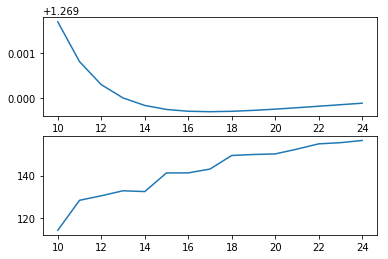

In [21]:
print(rmse_list)

plt.figure()
plt.subplot(211)
plt.plot(maxiter_list,rmse_list)
plt.subplot(212)
plt.plot(maxiter_list,running_time_list)
plt.show()

Overall, we can see that when $ Lambda $ =0.3 and rank=16, ALS gives the best RMSE at 1.27

What we can observe is that RMSE is montonic with regard to rank. The higher the rank the lower the RMSE; that makes perfect as the more complex the model is, the more accurate it would be. However, we observe there is a local minimum for RMSE when **lambda** is changed. This is becasue **lambda** is the regularization factor for overfitting the model. The higher the **lambda** is, the more penalty it would put on the model for overfitting. In this case, the model performs worse when **lambda = 0.5** than when **lambda=0.3** becasue the model lost too much detail in describing the data to prevent it from overfitting.

----------------------
Now, we have the best model, let's use ALS to make some recommendations. First, I will need a map to convert restaurant name into the integer business id

In [10]:
def find_restaurant_id(data,restaurant_list):
    """
    function to user restaurant name to find restaurant id
    
    --------------
    
    data: spark dataset that contains restaurant name, restaurant id combination
    
    restaurant_list: list, input list of restaurant name that needs to be transfer to restaurant id
    
    """
    final_list=[]
    if restaurant_list is None:
        return final_list
    for restaurant in restaurant_list:
        restaurant_id=data.where(col('name') \
                          .like(restaurant)) \
                          .select('business_id_int') \
                          .distinct() \
                          .rdd \
                          .map(lambda r:r[0]) \
                          .collect()    
                          
        final_list.extend(restaurant_id)
    return final_list

Next, define the function that would add new data into the model.

In [11]:
def add_new_user_data(train_data,my_fav,my_least_fav=None):
    """
    function to add new user's data into train model
    
    --------------
    
    
    parameters:
    
    train_data: spark dataframe, Initial data for user_id,business_id,rating combinations
    
    my_fav: list of strings, favourite restaurant list; Assume these restaurants are marked as 5
    
    my_least_fav: list of strings, least favourite restaurant list; Assume these restaurants are makred as 1
    """
    new_user_id=train_data.rdd.map(lambda r:r[1]).max()+1
    columns=['business_id_int','user_id_int','stars_review','name']
    print("initialize data for new userid {}".format(new_user_id))
    fav_list=find_restaurant_id(train_data,my_fav)
    fav_rows=[(restaurant_id,new_user_id,5,restaurant) for restaurant_id,restaurant in zip(fav_list,my_fav)]
    fav_df=spark.createDataFrame(fav_rows,columns)
    final_set=train_data.union(fav_df)
    if my_least_fav is not None:
        least_fav_list=find_restaurant_id(train_data,my_least_fav)
        least_fav_rows=[(restaurant_id,new_user_id,1,restaurant) for restaurant_id,restaurant in zip(least_fav_list,my_least_fav)]
        least_fav_df=spark.createDataFrame(least_fav_rows,columns)
        final_set=train_data.union(least_fav_df)
    return new_user_id,final_set

In [27]:
def find_personal_recommendation_als(train_data,my_fav,my_least_fav=None,reg_param=0.3,rank=16,maxiter=17):
    """
    function to give personal recommendations to the defined user who has record of favourite restaurant and least favourite restaurant
    
    -----------
    parameters:
    
    train_data: spark dataframe, Initial data for user_id,business_id,rating combinations
    
    my_fav: list of strings, favourite restaurant list; Assume these restaurants are marked as 5
    
    my_least_fav: list of strings, least favourite restaurant list; Assume these restaurants are makred as 1
    
    reg_param: lambda in ALS, defined the overfitting penalty of the ALS
    
    rank: rank of ALS, defined the complexity of ALS
    
    
    """
    best_regularization=reg_param
    best_rank=rank
    new_user_id,new_set=add_new_user_data(train_data,my_fav,my_least_fav)
    
    best_als=ALS(maxIter=maxiter, \
             regParam=best_regularization, \
             userCol="user_id_int", \
             itemCol="business_id_int", \
             ratingCol="stars_review_int", \
             rank=best_rank, \
             coldStartStrategy="drop", \
             checkpointInterval=2
             )
    model=best_als.fit(new_set)
    users=new_set.select(best_als.getUserCol()).where(col('user_id_int')==new_user_id)
    userSubsetRecs=model.recommendForUserSubset(users,10)
    print("Here are the top 10 recommandations for you given your favourite and least favourite food")
    for restaurant in userSubsetRecs.select("recommendations").collect()[0][0]:
        restaurant_id=restaurant.__getattr__("business_id_int")
        restaurant_name=train_data.where(col('business_id_int')==restaurant_id).select('name').distinct().collect()
        print(restaurant_name[0].__getattr__("name"))
    return userSubsetRecs


In [28]:
my_fav=['Emerald Chinese Restaurant']

find_personal_recommendation_als(ALS_data,my_fav)

initialize data for new userid 458670
Here are the top 10 recommandations for you given your favourite and least favourite food
Shawarma Q
Brando's Fried Chicken
Charlotte's Homemade Goodies
Sushi Making For the Soul
Pita Pit
Ten Ten Dim Sum
Porchetta Roll
Cuisine of India
The Dock On Queen
Debu's Nouvelle Indian Cuisine


DataFrame[user_id_int: int, recommendations: array<struct<business_id_int:int,rating:float>>]

Compare this to the result from KNN

-------------
(KNN recommendation)

Recommendations for Emerald Chinese Restaurant:

1: Kobe Sushi, with distance of 0.8729435047925027

2: Wonton Chai Noodle, with distance of 0.8717288246806103

3: Chako, with distance of 0.8693951111786435

4: Congee Dynasty, with distance of 0.8658084838350306

5: Dynasty BBQ, with distance of 0.861539455352046

6: McDonald's, with distance of 0.8548495321630935

7: Wild Wing, with distance of 0.854550339648705

8: Blue Lagoon Seafood Master, with distance of 0.8544684454549096

9: Viet Thai Restaurant, with distance of 0.8378466819037798

10: Happy Jade Seafood Chinese Restaurant, with distance of 0.7963704755081871

-------------

It is surprise to see that ALS gives totally different recommendations comparing to KNN. 

Let's take another example of J's Fish and Chips


In [29]:
my_fav=["J's Fish & Chips"]
find_personal_recommendation_als(ALS_data,my_fav)

initialize data for new userid 458670
Here are the top 10 recommandations for you given your favourite and least favourite food
Shawarma Q
Bar Bataviato
J's Fish & Chips
Millwood Melt Grilled Cheesery
Debe's Roti & Doubles
Ten Ten Dim Sum
Mrakovic Meat & Deli
Pita Pit
Sushi Making For the Soul
Urban Acorn Catering


DataFrame[user_id_int: int, recommendations: array<struct<business_id_int:int,rating:float>>]

Compared it to the KNN model

-------------------------------------------------------
1: Taza Xpress, with distance of 0.9176311421402781

2: Quesada Burritos and Tacos, with distance of 0.9038392772773323

3: Twisted Fork, with distance of 0.896251268968906

4: Yamato Sushi, with distance of 0.8955883310348774

5: St. Louis Bar & Grill, with distance of 0.8916467512822909

6: Otaru Sushi, with distance of 0.8879336370638948

7: Bakery Garden, with distance of 0.8687116746261058

8: Sunset Grill, with distance of 0.8267602678311907

9: Mrs. Greek Souvlaki Express, with distance of 0.7920633893787208

10: The Prince Albert Pub, with distance of 0.7846347538730261

Again, very different.